# Assignment 5: Long-Short Term Memory (Solution)
---

In this assignment, we will use Long-Short Term Memory (LSTM) ([link](https://en.wikipedia.org/wiki/Long_short-term_memory)) to predict the number of passengers in an airline for the next day given the number of passengers today. The data is represented as a time series.

First, let's import necessary libraries.

                    
                    import math
                    import numpy as np
                    import pandas as pd
                    import matplotlib.pyplot as plt
                    from sklearn.preprocessing import MinMaxScaler
                    from sklearn.metrics import mean_squared_error
                    from sklearn.model_selection import train_test_split

                    from tensorflow import keras
                    from keras.models import Sequential
                    from keras.layers import Dense, LSTM


In [ ]:
### import auxiliary libraries
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

### import keras and relevant functions
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM

The code for downloading the data and visualizing a subset of it is provided below.

                    airlines = pd.read_csv('https://github.com/weizi-li/weizi-li.github.io/blob/master/teaching/airline-passengers.csv')
                    print(f"Dataset\n{airlines.head()}\n")

                    subset_size = 40 
                    subset_months= airlines['Month'][0:subset_size]
                    subset_passengers = airlines['Passengers'][0:subset_size]

                    fig, ax = plt.subplots(figsize=(14,4), dpi = 80)
                    ax.plot(range(len(subset_months)), np.array(subset_passengers), '+', label = "Passenger count")
                    ax.plot(range(len(subset_months)), np.array(subset_passengers), alpha = 0.5)
                    ax.set_xticks(range(len(subset_months))) 
                    ax.set_xticklabels(subset_months); # ';' prevents displaying auxillary outputs
                    plt.xticks(rotation=45);
                    ax.legend()


<p align="center">
  <img src="https://user-images.githubusercontent.com/96804013/153318289-1be2e715-5180-48f7-bdb1-9f41b9952b4c.png")
"/>
</p>

<p align="center">
  <em>Figure 1:Visualization of raw dataset</em>
</p>




Dataset
     Month  Passengers
0  1949-01         112
1  1949-02         118
2  1949-03         132
3  1949-04         129
4  1949-05         121



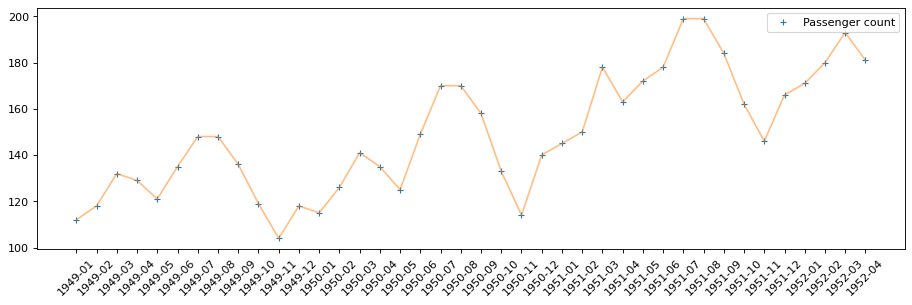

In [ ]:
"""
load the dataset, Visualize a subset of the dataset 
"""

# Download the full dataset
airlines = pd.read_csv('https://github.com/poudel-bibek/Intro-to-AI-Assignments/files/7999363/airline-passengers.csv')

# Take a peek into the full dataset
print(f"Dataset\n{airlines.head()}\n")

subset_size = 40 

subset_months= airlines['Month'][0:subset_size]
subset_passengers = airlines['Passengers'][0:subset_size]

fig, ax = plt.subplots(figsize=(14,4), dpi = 80)
ax.plot(range(len(subset_months)), np.array(subset_passengers), '+', label = "Passenger count")
ax.plot(range(len(subset_months)), np.array(subset_passengers), alpha = 0.5)

ax.set_xticks(range(len(subset_months))) 
ax.set_xticklabels(subset_months); # ';' prevents displaying auxillary outputs
plt.xticks(rotation=45);
ax.legend()

We will only be working with the Passengers column. Let's use the code below to process the data.

- extract the Passengers column 
- take a look at it 
- convert its type 
- rehsape it 
- print its shape and the minimum and maximum values 

                    passengers = airlines['Passengers']
                    print(f"Passengers column\n{passengers.head()}")

                    dataset = passengers.values.astype('float32').reshape(-1,1)
                    print(f"\nBefore Normalization :\n shape ={dataset.shape}, max = {np.max(dataset)}, min = {np.min(dataset)}")

In [ ]:
# Use the passengers column (the dataset we will be using will only be this column)
passengers = airlines['Passengers']
print(f"Passengers column\n{passengers.head()}")

# Get the values of passengers as a numpy array of data-type float32
dataset = passengers.values.astype('float32').reshape(-1,1)
print(f"\nBefore Normalization :\n shape ={dataset.shape}, max = {np.max(dataset)}, min = {np.min(dataset)}")

Passengers column
0    112
1    118
2    132
3    129
4    121
Name: Passengers, dtype: int64

Before Normalization :
 shape =(144, 1), max = 622.0, min = 104.0


Next, let's normalize the data, i.e., the `dataset` variable, using Minmax Scaler ([link](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)). 
  - Instantiate a MinMaxScaler() object and make the feature range between 0 and 1
  - Use the `fit_transform` function of MinMaxScaler to scale the dataset
  - Print the shape of dataset and the minimum and maximum values after normalization 
  
The shape `(144,1)` indicates the data has the format `[[data 0], [data 1], [data 2].... [data 143]]`.

In [ ]:
### normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
print(f"\nAfter Normalization:\n shape ={dataset.shape}, max = {np.max(dataset)}, min = {np.min(dataset)}")


After Normalization :
 shape =(144, 1), max = 1.0, min = 0.0


Now use the following code to reshape the dataset to `(144,)`. 
Now we have made the data look like this `[data 0, data 1, data2,.... data 143]`.

                    dataset = dataset.reshape(-1)
                    print(dataset.shape) 



In [ ]:
dataset = dataset.reshape(-1)
print(dataset.shape) 

(144,)


The prediction problem is formulated in such a way that we want to look at the passenger number of Day 0 (today) to predict the pessenger number of Day 1 (tomorrow), i.e., there exists an 1 day difference between input feature and output label (`look back = 1`). The below figure demonstrates how we convert a single sequence of data into labelled examples.  

<p align="center">
  <img src="https://user-images.githubusercontent.com/96804013/153277436-42e975b8-043a-4d8a-8752-eea10d93767e.png")
"/>

</p>

<p align="center">
  <em>Figure 2: Conversion of Sequential data to (x,y) format (Figure Drawn for look back = 1).</em>
</p>

<br>

Now, use the following code to prepare the training set.  

                    def gen_dataset(dset, look_back):
                      X = []
                      y = []
                      for i in range(len(dset)-look_back-1):
                        y_value = dset[i + look_back] # output label
                        x_value = dset[i : i + look_back] # input feature
                        y.append(y_value)
                        X.append(x_value)
                      
                      return np.array(X), np.array(y)


In [ ]:
def gen_dataset(dset, look_back):

  X = []
  y = []

  for i in range(len(dset)-look_back-1):
    y_value = dset[i + look_back] # output label
    x_value = dset[i : i + look_back] # input feature
    y.append(y_value)
    X.append(x_value)
  
  return np.array(X), np.array(y)

We can make use of the function we just wrote as follows.

                    look_back = 1
                    data_X, data_y = gen_dataset(dataset, look_back)
                    print(data_X.shape, data_y.shape)

In [ ]:
# How many days to look back 
look_back = 1
data_X, data_y = gen_dataset(dataset, look_back)

print(data_X.shape, data_y.shape)

(142, 1) (142,)


Let's prepare for learning:

- Split the dataset (data_X, data_y) into training set and test set with 7:3 ratio.
- Set `shuffle` to `True` and `random_state` to `42` for repeatable experiments.
- Store the values in `X_train`, `X_test`, `y_train`, and `y_test`
- Check the shapes of `X_train`, `X_test`, `y_train`, and `y_test`
- Reference ([link](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.3, shuffle=True, random_state=42)
print(f"Train shape x = {X_train.shape}, y = {y_train.shape} \nTest shape x = {X_test.shape}, y = {y_test.shape}")

Train shape x = (99, 1), y = (99,) 
Test shape x = (43, 1), y = (43,)


Next, build an LSTM model with two layers: 

- 1st layer: LSTM layer with 100 units; specify `input_shape = (1, look_back)`
- 2nd layer: dense layer with one unit


Now compile and train the model:

- for compiling, set `loss` to `mean_squared_error` and `optimizer` to `adam`
- for training, set `epochs` to 10, `batch_size` to 1, and `verbose` to 2


References
- LSTM ([link](https://keras.io/api/layers/recurrent_layers/lstm/))
- Dense ([link](https://keras.io/api/layers/core_layers/dense/))
- Compile and fit ([link](https://keras.io/api/models/model_training_apis/))


In [ ]:
"""
Model build, train
"""

### build, complie, and train the LSTM model
lstm = Sequential()
lstm.add(LSTM(100, input_shape=(1,  look_back)))
lstm.add(Dense(1)) # Default activation is relu

lstm.summary() 

lstm.compile(loss='mean_squared_error', optimizer='adam')
lstm.fit(X_train, y_train, epochs=10, batch_size=1, verbose=2) # Try setting different values to epochs [1, 2, 10, 50] to see is model gets better

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
99/99 - 4s - loss: 0.0782 - 4s/epoch - 43ms/step
Epoch 2/10
99/99 - 0s - loss: 0.0254 - 389ms/epoch - 4ms/step
Epoch 3/10
99/99 - 0s - loss: 0.0166 - 389ms/epoch - 4ms/step
Epoch 4/10
99/99 - 0s - loss: 0.0103 - 445ms/epoch - 4ms/step
Epoch 5/10
99/99 - 0s - loss: 0.0066 - 417ms/epoch - 4ms/step
Epoch 6/10
99/99 - 1s - loss: 0.0056 - 524ms/epoch - 5ms/step
Epoch 7/10
99/99 - 0s - loss: 0.0050 - 420ms/epoch - 4ms/step
Epoch 8/10
99/99

Now the model is trained. Let's test it to see the error (RMSE). We have to reverse the normalization procedure for the predictions. To do so, we use the same scaler that is instantiated and `fitted` earlier.

    
                    pred_train = lstm.predict(X_train)
                    pred_test = lstm.predict(X_test)

                    pred_train = scaler.inverse_transform(pred_train)
                    pred_test = scaler.inverse_transform(pred_test)

                    y_train = scaler.inverse_transform(y_train.reshape(-1,1))
                    y_test = scaler.inverse_transform(y_test.reshape(-1,1))
              
                    train_rmse = math.sqrt(mean_squared_error(y_train, pred_train))
                    test_rmse = math.sqrt(mean_squared_error(y_test, pred_test))

                    print(f"Train RMSE = {train_rmse} \nTest RMSE = {test_rmse}")




In [ ]:
"""
Test
"""
### make predictions
pred_train = lstm.predict(X_train)
pred_test = lstm.predict(X_test)

### invert the predictions (in [0,1]) to the original range
pred_train = scaler.inverse_transform(pred_train)
pred_test = scaler.inverse_transform(pred_test)

y_train = scaler.inverse_transform(y_train.reshape(-1,1))
y_test = scaler.inverse_transform(y_test.reshape(-1,1))

#print(pred_train.shape, y_train.shape)

### compute the RMSE
train_rmse = math.sqrt(mean_squared_error(y_train, pred_train))
test_rmse = math.sqrt(mean_squared_error(y_test, pred_test))

print(f"Train RMSE = {train_rmse} \nTest RMSE = {test_rmse}")

Train RMSE = 34.452887612560865 
Test RMSE = 33.60868672296178


Next, let's compare some predictions against the actual labels. 
        
                    def plot(predictions, ground_truths, type = '', plot_x_size = 30):
                      predictions = predictions.reshape(-1)[0:plot_x_size]
                      ground_truths = ground_truths.reshape(-1)[0: plot_x_size]
                      x_axis = range(plot_x_size)

                      fig, ax = plt.subplots(figsize=(12,4), dpi = 80)
                      ax.plot(x_axis, predictions, alpha = 0.5) 
                      ax.plot(x_axis, predictions, 'o',label = "predictions") 
                      ax.plot(x_axis, ground_truths, alpha = 0.5) 
                      ax.plot(x_axis, ground_truths, 'x', label = "ground truths") 

                      ax.set_xticks(x_axis);
                      ax.set_xlabel("Day number")
                      ax.set_ylabel("Passenger Count")
                      ax.set_title(f"Model performance on a subset of {type} set")
                      ax.legend()
                      plt.show()

                    plot(pred_train, y_train, 'train')
                    plot(pred_test, y_test, 'test')

<p align="center">
  <img src="https://user-images.githubusercontent.com/96804013/153318480-c85d408d-41e0-4470-a815-ed1467e9b0dd.png")
"/>
</p>

<p align="center">
  <em>Figure 3:Visualization of LSTM predictions on train and test</em>
</p>


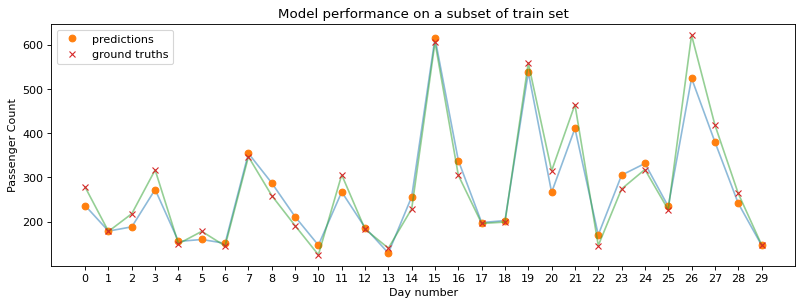

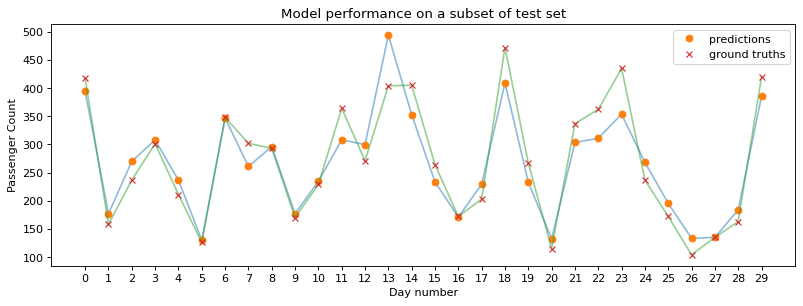

In [ ]:
"""
Plot to see performance
"""

def plot(predictions, ground_truths, type = '', plot_x_size = 30):
  predictions = predictions.reshape(-1)[0:plot_x_size]
  ground_truths = ground_truths.reshape(-1)[0: plot_x_size]
  x_axis = range(plot_x_size)

  fig, ax = plt.subplots(figsize=(12,4), dpi = 80)
  ax.plot(x_axis, predictions, alpha = 0.5) 
  ax.plot(x_axis, predictions, 'o',label = "predictions") 
  ax.plot(x_axis, ground_truths, alpha = 0.5) 
  ax.plot(x_axis, ground_truths, 'x', label = "ground truths") 

  ax.set_xticks(x_axis);
  ax.set_xlabel("Day number")
  ax.set_ylabel("Passenger Count")
  ax.set_title(f"Model performance on a subset of {type} set")
  ax.legend()
  plt.show()

plot(pred_train, y_train, 'train')
plot(pred_test, y_test, 'test')